# dataset
BTC price can be downloaded from https://finance.yahoo.com/quote/BTC-USD/history/

We need change time range, click apply before download.

When we download this file, we have csv file BTC-USD.csv contain: Date, Open, High, Low, Close*, Adj Close** and Volume columns.

In this project, I use Open price to train and evaluate model.

# import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Preprocessing and Visualizing
We need to check data, preprocessing & Visualization include:
- check null row
- remove null data
- describe Open columns to view min max
- plot Open price and review it

In [2]:
#load file
df = pd.read_csv("/content/BTC-USD.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...,...
3445,2024-02-22,51854.644531,52009.613281,50926.292969,51304.972656,51304.972656,2.541390e+10
3446,2024-02-23,51283.906250,51497.933594,50561.777344,50731.949219,50731.949219,2.142708e+10
3447,2024-02-24,50736.371094,51684.195313,50585.445313,51571.101563,51571.101563,1.517408e+10
3448,2024-02-25,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#check na --> at day 02/25/2024, all price is Null, I download data at 02/26/2024, maybe this system have some error or need time to compute price at yesterday?
df.Open.isna().sum()

1

In [4]:
#only use Open column and dropna
df = df[['Open']].dropna()

In [5]:
df.Open.describe()

count     3449.000000
mean     15069.681277
std      16523.172718
min        176.897003
25%        970.940979
50%       8405.567383
75%      25934.021484
max      67549.734375
Name: Open, dtype: float64

In [6]:
len(df)

3449

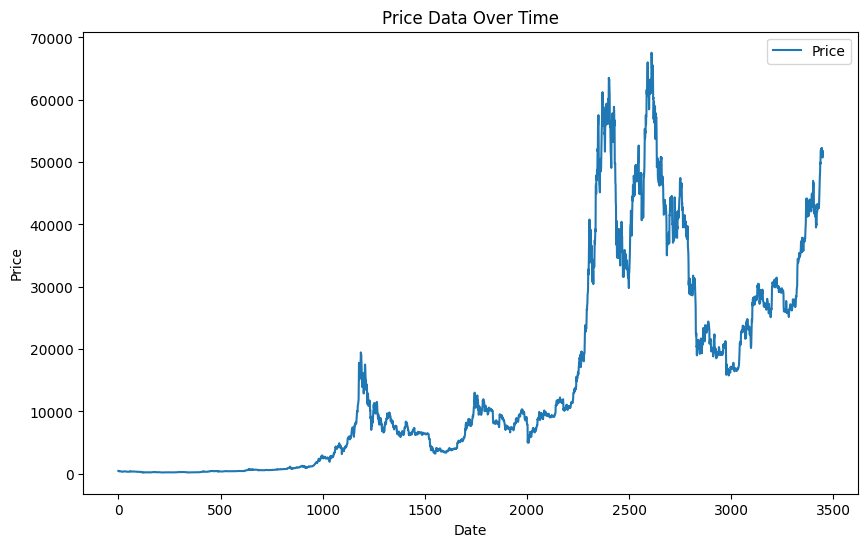

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df['Open'], label='Price')
plt.title('Price Data Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [8]:
df['Log_Price'] = df['Open'].apply(lambda x: np.log(x))

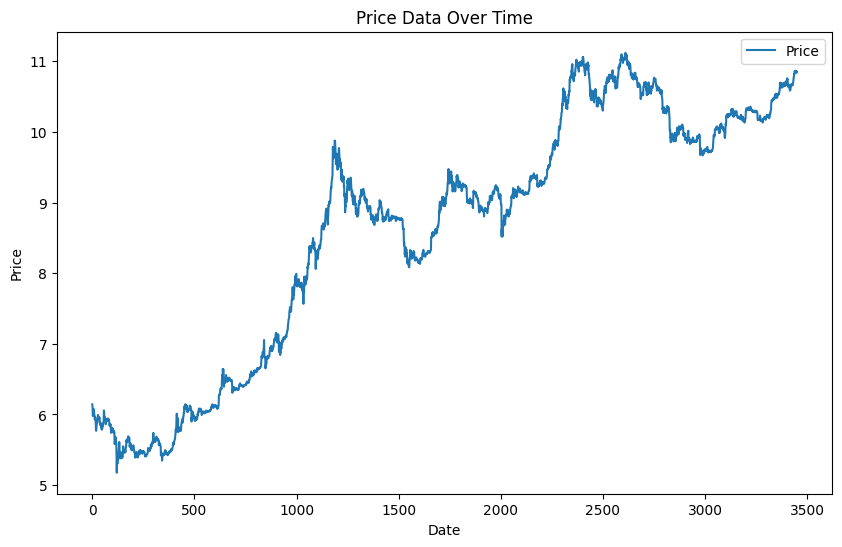

In [9]:
# Assuming df is your DataFrame with a column 'Price'
# If the DataFrame has a datetime index, you can use df.index instead of df['Date']

# Example code:
plt.figure(figsize=(10, 6))
plt.plot(df['Log_Price'], label='Price')
plt.title('Price Data Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Prepair data
Before building model, we need convert df.Open to dataset include input and output. And we need split dataset to train dataset, val dataset, test dataset

I want to use basic LSTM model, then I need create dataset with input is sequence of past price (in this project, we use sequence price of 30 day before output) and output is the next price.

I use function create_sequences to create dataset

In [10]:
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

In [11]:
# Hyperparameters
sequence_length = 30  # Number day as input to use to predict output price (price at next day)

# Create sequences and target
sequences, target = create_sequences(df['Open'].values, sequence_length)

In [12]:
sequences.shape, target.shape

((3419, 30), (3419,))

# split dataset
split dataset (sequences, target) to train, val and test data.

I use 60 lastest day as test data. 20% next lastest as val data.

In [13]:
test_size = 60
X_test, y_test = sequences[-test_size:], target[-test_size:]
X_train, y_train = sequences[:-test_size], target[:-test_size]

train_size = int(0.8 * len(X_train))
X_val, y_val = X_train[train_size:], y_train[train_size:]
X_train, y_train = X_train[:train_size], y_train[:train_size]

In [14]:
X_train.shape, X_val.shape, X_test.shape

((2687, 30), (672, 30), (60, 30))

In [15]:
y_train.shape, y_val.shape, y_test.shape

((2687,), (672,), (60,))

#Normalize data
dataset need normalized before train model. I use MinMaxScaler to normalize dataset.

First we fit MinMaxScaler with train data and then normalzie all data from this MInMaxScaler

In [16]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape((-1, 30))
X_train.shape

(2687, 30)

In [17]:
X_val = scaler.transform(X_val.reshape(-1, 1)).reshape((-1, 30))
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape((-1, 30))

y_train = scaler.transform(y_train.reshape(-1, 1)).reshape(-1)
y_val = scaler.transform(y_val.reshape(-1, 1)).reshape(-1)
y_test = scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

#train model
first reshape dataset to fit LSTM:
- input have shape: (num_data, len, feature) --> (num_data, 30, 1)
- output have shape: (num_data)

In [18]:
# Reshape the data for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## create LSTM model

In [19]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
optimizer = tf.keras.optimizers.experimental.AdamW(weight_decay = 1e-3)
model.compile(optimizer=optimizer, loss='mse')

## set hyperarameters
set epoch, batch_size

In [21]:
# Hyperparameters
batch_size = 32
epochs = 50

##train model

In [22]:
# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/50
84/84 [==============================] - 5s 19ms/step - loss: 0.0466 - val_loss: 0.0110
Epoch 2/50
84/84 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 3/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 9.5418e-04 - val_loss: 0.0026
Epoch 5/50
84/84 [==============================] - 1s 13ms/step - loss: 8.2619e-04 - val_loss: 0.0018
Epoch 6/50
84/84 [==============================] - 1s 14ms/step - loss: 7.4646e-04 - val_loss: 0.0014
Epoch 7/50
84/84 [==============================] - 1s 13ms/step - loss: 6.5498e-04 - val_loss: 0.0018
Epoch 8/50
84/84 [==============================] - 1s 13ms/step - loss: 6.1632e-04 - val_loss: 0.0011
Epoch 9/50
84/84 [==============================] - 1s 16ms/step - loss: 5.7055e-04 - val_loss: 0.0011
Epoch 10/50
84/84 [==============================] - 1s 18ms/step - loss: 5.2330e-04 

## eval test loss

In [23]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

2/2 [==============================] - 0s 12ms/step - loss: 4.7529e-04
Model Loss: 0.0004752878157887608


#make predict

In [24]:
# Make predictions
predicted_normalized_prices = model.predict(X_test)

# Inverse transform the normalized prices to get the predicted prices
predicted_prices = scaler.inverse_transform(predicted_normalized_prices)

2/2 [==============================] - 0s 10ms/step


In [25]:
max_error_percent = 0
mean_error_percent = 0
for i, (predict, label) in enumerate(zip(predicted_prices.reshape(-1), scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1))):
    error_percent = np.abs(predict-label)/label*100
    print(f'{i} predict price: {predict}, true price: {label}, error = {error_percent}')
    max_error_percent = max(error_percent, max_error_percent)
    mean_error_percent += error_percent
print('max_error_percent', max_error_percent)
print('mean_error_percent', mean_error_percent/len(predicted_prices))

0 predict price: 44225.1640625, true price: 43468.199219, error = 1.7414221364135274
1 predict price: 44258.2265625, true price: 42614.644531, error = 3.8568479206822417
2 predict price: 43989.4375, true price: 42091.753906, error = 4.508445046594971
3 predict price: 43609.89453125, true price: 42152.097656, error = 3.458420710511181
4 predict price: 43341.140625, true price: 42280.234375, error = 2.5092250922509227
5 predict price: 43193.578125, true price: 44187.140625, error = 2.248533138706574
6 predict price: 43759.609375, true price: 44961.601563, error = 2.6733749382031475
7 predict price: 44500.015625, true price: 42855.816406, error = 3.8365835886160062
8 predict price: 44372.4765625, true price: 44192.980469, error = 0.40616426318181686
9 predict price: 44702.73828125, true price: 44178.953125, error = 1.1855988410771108
10 predict price: 44914.76953125, true price: 43998.464844, error = 2.082583313983404
11 predict price: 44993.94140625, true price: 43948.707031, error = 2.3

## predict multiple day
We can see that the predict price is nearly with true price (low average error beween predict price and true price).

Then I use 30 first test day as input. Loop to predict next day and add predict price as lastest input.

In [26]:
# Make predictions
predicted_normalized_prices = []
X = X_test[30].reshape(-1).tolist()

for i in range(30):
    input_ = np.array(X).reshape((1, 30, 1))
    predict = model.predict(input_)
    predicted_normalized_prices.append(predict[0][0])
    X = X[1:] + [predict[0][0]]

predicted_normalized_prices = np.array(predicted_normalized_prices).reshape((-1, 1))
predicted_prices = scaler.inverse_transform(predicted_normalized_prices)

1/1 [==============================] - 0s 40ms/step


In [27]:
max_error_percent = 0
mean_error_percent = 0
for predict, label in zip(predicted_prices.reshape(-1), scaler.inverse_transform(y_test[30:].reshape(-1, 1)).reshape(-1)):
    error_percent = np.abs(predict-label)/label*100
    print(f'predict price: {predict}, true price: {label}, error = {error_percent}')
    max_error_percent = max(error_percent, max_error_percent)
    mean_error_percent += error_percent
print('max_error_percent', max_error_percent)
print('mean_error_percent', mean_error_percent/len(predicted_prices))

predict price: 40685.29296875, true price: 41815.625, error = 2.703133173903296
predict price: 40853.6953125, true price: 42126.125, error = 3.020523932595272
predict price: 41090.0234375, true price: 42030.914063, error = 2.2385680789375617
predict price: 41388.80859375, true price: 43300.226563, error = 4.414337108534442
predict price: 41736.01953125, true price: 42946.25, error = 2.8180119771807783
predict price: 42121.26953125, true price: 42569.761719, error = 1.0535463898305732
predict price: 42537.51171875, true price: 43077.640625, error = 1.2538497893882738
predict price: 42979.18359375, true price: 43184.964844, error = 0.4765113297958203
predict price: 43441.5078125, true price: 42994.941406, error = 1.0386487151664847
predict price: 43921.33203125, true price: 42577.621094, error = 3.1559089087749728
predict price: 44415.2265625, true price: 42657.390625, error = 4.120823875405529
predict price: 44920.22265625, true price: 43090.019531, error = 4.247394513092086
predict pri